# Results

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

In [3]:
data = pd.read_csv("data\cleaned\data_all.csv")

In [4]:
data["date"] = pd.to_datetime(data["date"])

In [5]:
def smooth_data(grouped_df, cols):
    groups = [gr for name, gr in grouped_df]
    for df in groups:
        df.reset_index(drop = True, inplace = True)
        for col in cols:
            df[col] = savgol_filter(df[col], 15, 3)
    return pd.concat(groups).sort_values(by = ["date", "state"]).reset_index(drop = True)

In [6]:
data = smooth_data(data.groupby("state"), ["usage", "tavg", "tmin", "tmax"])

In [7]:
data["month"] = data["date"].dt.month

From the exploratory data analyses, we found that the differences in power consumption and temperature and mainly between months. I plot the medians of the temperature together with the median power consumption and total rainfall per month for every state. From here, we can see find regularities in the data, correlations between the variables and possibly find a way to construct a model for the power consumption.

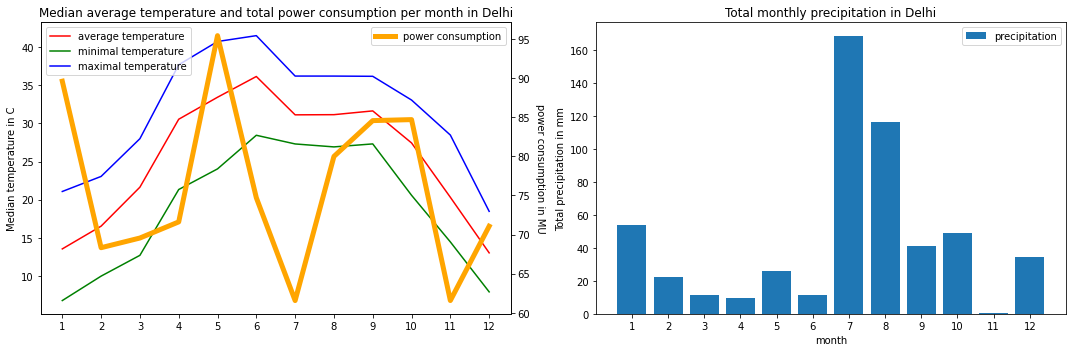

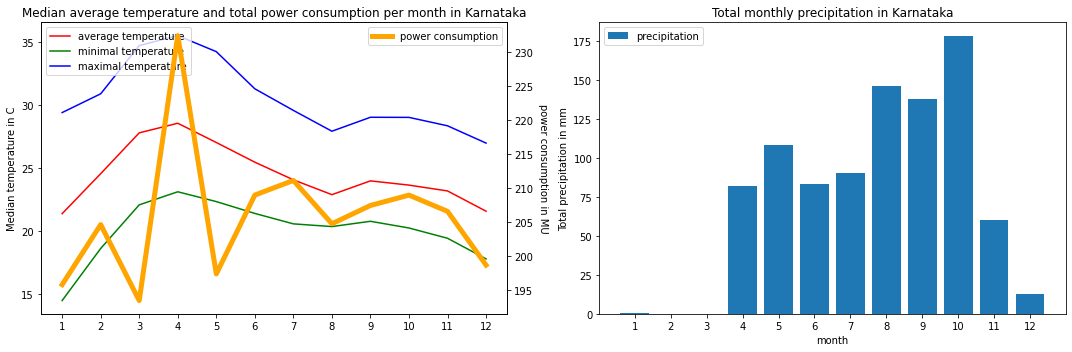

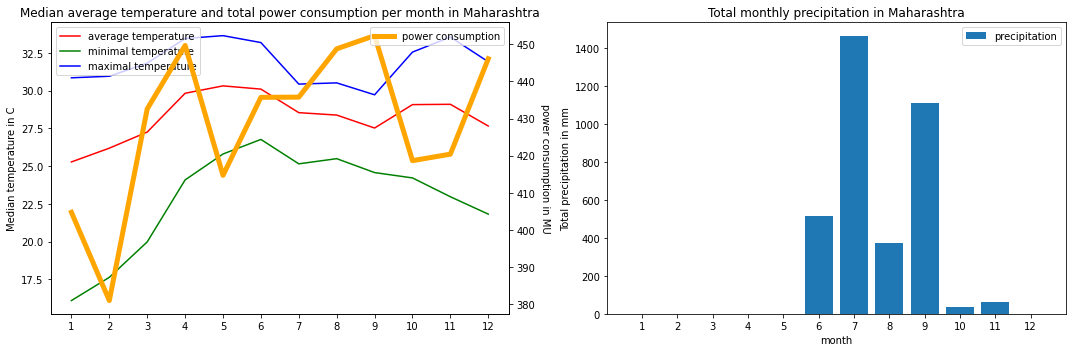

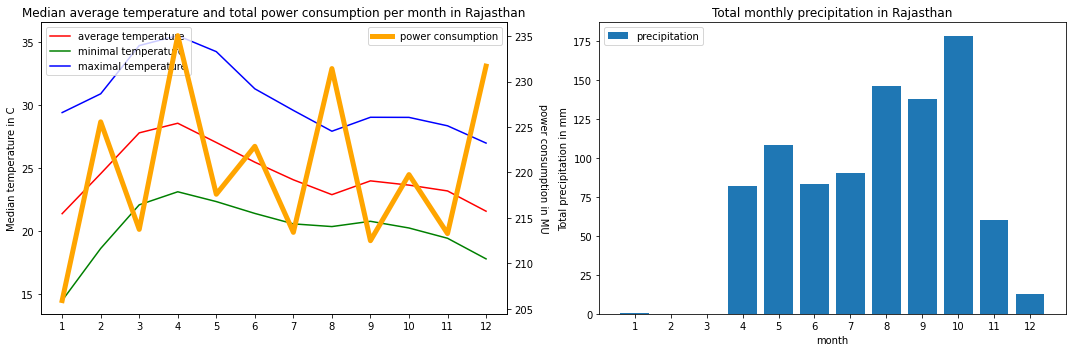

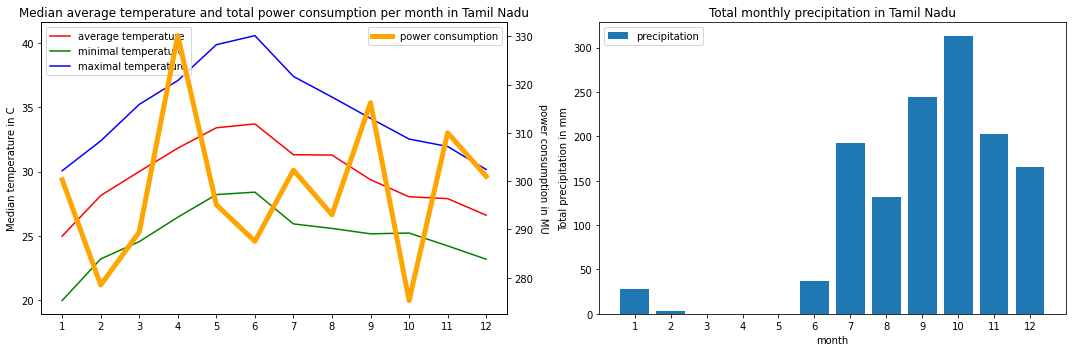

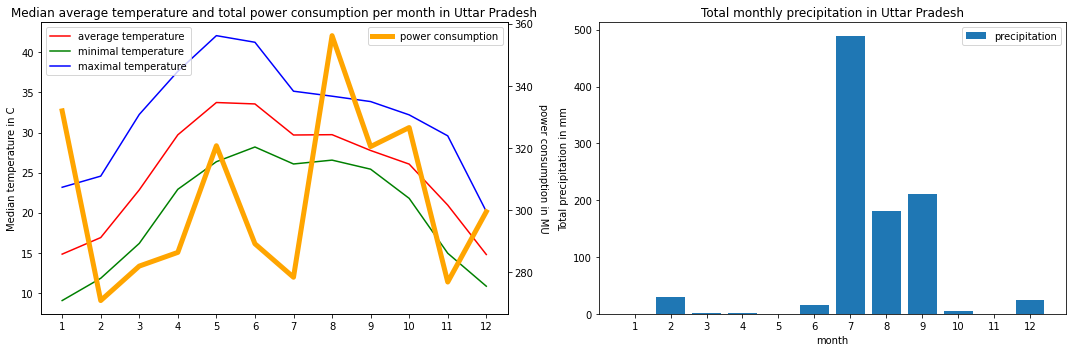

In [27]:
for name, group in data.groupby("state"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
    tavg = group.groupby("month")["tavg"].median()
    tmin = group.groupby("month")["tmin"].median()
    tmax = group.groupby("month")["tmax"].median()
    usage = group.groupby("month")["usage"].median()
    prcp = group.groupby("month")["prcp"].sum()
    
    ax1.plot(tavg, label = "average temperature", color = "red")
    ax1.plot(tmin, label = "minimal temperature", color = "green")
    ax1.plot(tmax, label = "maximal temperature", color = "blue")
    ax1.legend(loc = "upper left")
    ax1.set_ylabel("Median temperature in C")
    
    ax3 = ax1.twinx()
    ax3.plot(usage, color = "orange", label = "power consumption", linewidth = 5)
    ax3.set_title("Median average temperature and total power consumption per month in " + name)
    ax3.set_ylabel("power consumption in MU", rotation = 270, labelpad = 15)
    ax3.set_xlabel("month")
    ax3.set_xticks(range(1,13))
    ax3.legend(loc = "upper right")
    
    ax2.bar(prcp.index, prcp, label = "precipitation")
    ax2.set_xticks(range(1,13))
    ax2.legend()
    ax2.set_xlabel("month")
    ax2.set_ylabel("Total precipitation in mm")
    ax2.set_title("Total monthly precipitation in " + name)
    
    fig.tight_layout()
    plt.show()

# Discussion

Immediately we can see many complicated patterns. However, most of the drops and rises of power consumption have reasonable explanations. Take for example the first plot that represents the situation in Delhi. It starts high since the average temperature in January is low and people use heating. The same is applicable for Uttar Pradesh since that region also has low temperatures in January. The same pattern is not that apparent for the other states possibly because their average temperature in January is higher than Delhi and Uttar Pradesh (15° against 20°+). We can observe similar patterns on the other end of the plot in December. We can also see that for most states when the temperature peaks, the power consumption peaks as well. That is because when the weather is hot, people use cooling. We can also notice that sudden changes in the temperature lead to sudden changes to the consumption. The same applies for gradual changes. There are also irregularities in the power consumption that are possibly caused by increase in the rainfall. For instance, the peaks of power consumption in August and September in the state of Maharashtra directly follow really heavy rainfall which is on average 10x times heavier than the rainfall in some of the other states (1400mm+ in July). Similar behavior is also observed in Uttar Pradesh.

It appears that there are a lot of not so clearly defined rules and dependencies in the data, which makes it complicated for modelling. However, a user of __[Stack Overflow](https://stackoverflow.com/questions/29777890/data-visualization-how-to-represent-kwh-usage-by-year-against-average-temperatu)__ performed a similar task and modeled the relationship between temperature and power consumption using a second degree polynomial fitting. I attempt to do the same for every state. That works best for modelling the relationship between 2 variables, so I choose the average temperature as the only describing variable. Minimal and maximal temperature are highly correlated with the average temperature anyway and the precipitation is correlated with drops in the temperature so it will be appropriate to leave it out as well.

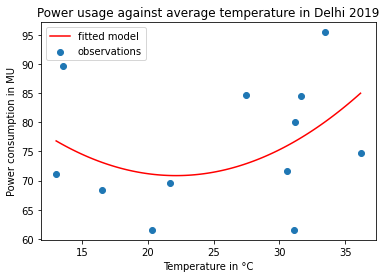

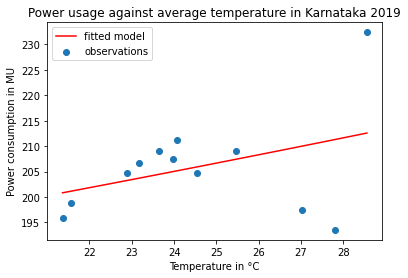

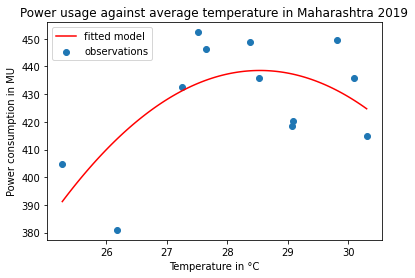

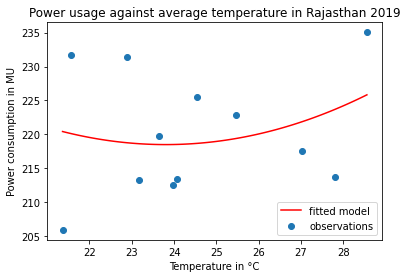

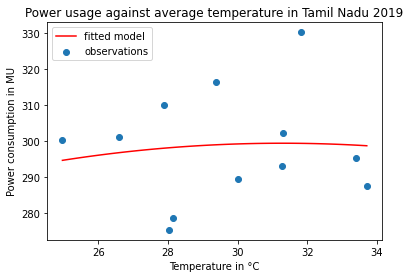

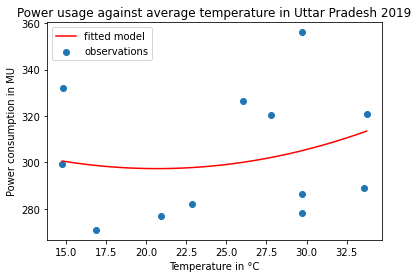

In [28]:
for name, group in data.groupby("state"):
    tavg = group.groupby("month")["tavg"].median()
    usage = group.groupby("month")["usage"].median()
    x = np.linspace(min(tavg), max(tavg), 100)
    p = np.polyfit(tavg, usage, 2)
    y = p[0]*x*x + p[1]*x + p[2]
    
    plt.plot(x,y, color = "red", label = "fitted model")
    plt.scatter(tavg,usage, label = "observations")
    plt.title("Power usage against average temperature in " + name + " 2019")
    plt.xlabel("Temperature in °C")
    plt.ylabel("Power consumption in MU")
    plt.legend()
    plt.show()

The models are definitely not perfected yet they are simplistic and quite descriptive of the data. The models that have a positive coeffcient in front of the square of the temperature (the concave up parabolas) start at lower temperatures compared to the others. That is expected since power is used both for cooling and heating and the vertex of the parabola can be considered the preferred living temperature for that state. The farther the current temperature is from the preferred one, the higher the power consumption. The other states, namely Tamil Nadu and Maharashtra seem to use the power primarily for cooling, which is expected since the minimal temperature there is around 24-25° and the result is a cocave down parabola. The power consumption then appears to be levelling off as the temperature increases, only the parabola in Maharashtra is severly curved but we already explained abnormalities in that state due to exceptional levels of rainfall.

# Conclusion

From daily life we know that there are multiple factors other than the weather that influence the electricity consumption, such as supply, price, etc. However, I have shown that we can make some quite accurate claims about the monthly tendencies of electricity consumption using only the weather data by looking at 6 examples in the country of India. We managed to find the preferred temperature and effect of rainfall in those states among other findings. Defining relationshpis between the variables is certainly difficult but possible. I would imagine that even stronger claims can be made if the study is repeated with more variables and a larger time interval.

# References

1. Statistical tests mentioned:
- __[Shapiro-Wilk](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test)__
- __[Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test)__
- __[Wilcoxon rank-sum test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)__
- __[t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)__
- __[Kruskal-Wallis](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance)__
- __[ANOVA](https://en.wikipedia.org/wiki/One-way_analysis_of_variance)__
- __[Dunn](https://www.statology.org/dunns-test/)__
- __[Tukey HSD](https://en.wikipedia.org/wiki/Tukey%27s_range_test)__
2. Study on factors influencing power consumption: __[here](https://pdfs.semanticscholar.org/171b/b509249400e37df8355dd1b2417b3d6736cd.pdf)__
3. Stack overflow similar modelling task: __[here](https://stackoverflow.com/questions/29777890/data-visualization-how-to-represent-kwh-usage-by-year-against-average-temperatu)__